In [19]:
import matplotlib.pyplot as plt
from mxnet import init, context, nd, gluon, autograd
from mxnet.gluon import nn
from IPython import display

In [16]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
      """A utility function to set matplotlib axes"""
      axes.set_xlabel(xlabel)
      axes.set_ylabel(ylabel)
      axes.set_xscale(xscale)
      axes.set_yscale(yscale)
      axes.set_xlim(xlim)
      axes.set_ylim(ylim)
      if legend: axes.legend(legend)
      axes.grid()
    
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [7]:
def get_dataloader(arrs, batch_size, shuffle=True):
    dataset = gluon.data.ArrayDataset(*arrs)
    dataloader = gluon.data.DataLoader(dataset, batch_size, shuffle, num_workers=4)
    return dataloader

In [14]:
def get_network():
    network = nn.Sequential()
    network.add(nn.Dense(10, activation='relu'))
    network.add(nn.Dense(1))
    return network

In [4]:
T = 1000
tau = 4
time = nd.arange(0, T)
x = nd.sin(0.01*time) + 0.02*nd.random.normal(shape=T)

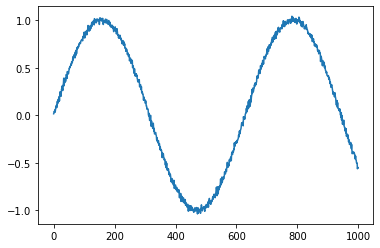

In [5]:
plt.plot(time.asnumpy(), x.asnumpy())
plt.show()

In [9]:
features = nd.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:]

batch_size, n_train = 16, 600
train_iter = get_dataloader((features[:n_train], labels[:n_train]), batch_size)

In [11]:
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    print(X)
    print(y)
    break

(16, 4)
(16,)

[[-0.84771097 -0.8628725  -0.86577505 -0.8238391 ]
 [ 0.3556228   0.36959895  0.3574752   0.35046625]
 [-0.3821394  -0.38559794 -0.3560728  -0.36191928]
 [-0.47669664 -0.4657828  -0.48688826 -0.46495205]
 [ 0.9101165   0.9457576   0.95513654  0.9762254 ]
 [ 0.20022343  0.15788677  0.193028    0.17551361]
 [-0.750543   -0.7409178  -0.755961   -0.71911186]
 [ 0.7831355   0.7528519   0.7644911   0.7534805 ]
 [-0.39106932 -0.41275287 -0.37587842 -0.3821394 ]
 [-0.98658407 -0.96974254 -0.98889935 -0.99833965]
 [-0.8944258  -0.9000548  -0.90748423 -0.90583825]
 [ 0.0886694   0.08706357  0.10546511  0.07962727]
 [ 0.69080687  0.6929722   0.6814871   0.63878626]
 [-0.7581923  -0.78940105 -0.8029949  -0.7773962 ]
 [-0.46495205 -0.44890016 -0.4478266  -0.43697017]
 [-1.0068622  -1.001342   -0.98658407 -0.96974254]]
<NDArray 16x4 @cpu_shared(0)>

[-0.82709605  0.37436855 -0.29011804 -0.44890016  0.9359082   0.16050258
 -0.6687196   0.7803766  -0.38559794 -1.0368702  -0.8824502   0.

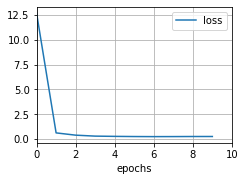

In [20]:
ctx = context.gpu()
net = get_network()
net.initialize(init=init.Xavier(), ctx=ctx)

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':0.01})

epochs = 10
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss'])

for epoch in range(epochs):
    lo = 0
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
        lo += l.sum().asscalar()
    animator.add(epoch, lo)

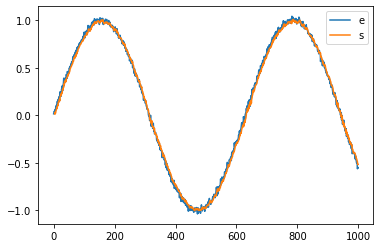

In [25]:
estimates = net(features.as_in_context(ctx))
plt.plot(time.asnumpy(), x.asnumpy())
plt.legend('data')
plt.plot(time[tau:].asnumpy(), estimates.asnumpy())
plt.legend('estimates')
plt.show()


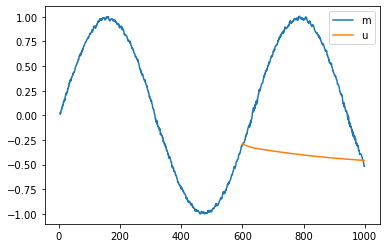

In [32]:
predictions = nd.zeros(T)
predictions[:n_train] = x[:n_train]
for i in range(n_train, T):
    predictions[i] = net(predictions[i-tau:i].reshape(1, -1).as_in_context(ctx)).reshape(1)

plt.plot(time[tau:].asnumpy(), estimates.asnumpy())
plt.legend('estimates')
plt.plot(time[n_train:].asnumpy(), predictions[n_train:].asnumpy())
plt.legend('multistep')
plt.show()